In [14]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'AppleGothic'

mpl.rcParams['axes.unicode_minus'] = False

In [15]:
df = pd.read_csv('./data/before_scaling.csv')


=== 클러스터별 학생 수 ===
cluster
0     53
1     39
2    223
Name: count, dtype: int64

=== 클러스터별 G3 평균/중앙값 ===
                            mean  median
cluster cluster_label                   
0       Low            10.000000     9.0
1       Mid            10.358974    10.0
2       High           12.228700    12.0

=== 클러스터별 주요 특성 평균 ===
                       studytime  absences  study_efficiency  \
cluster cluster_label                                          
0       Low                 1.72     14.81              0.25   
1       Mid                 2.03     10.49              0.37   
2       High                2.16      3.98              0.90   

                       studytime_absences  total_alcohol  alcohol_freetime  \
cluster cluster_label                                                        
0       Low                         25.38           6.64             24.00   
1       Mid                         22.21           3.41             10.31   
2       High                    

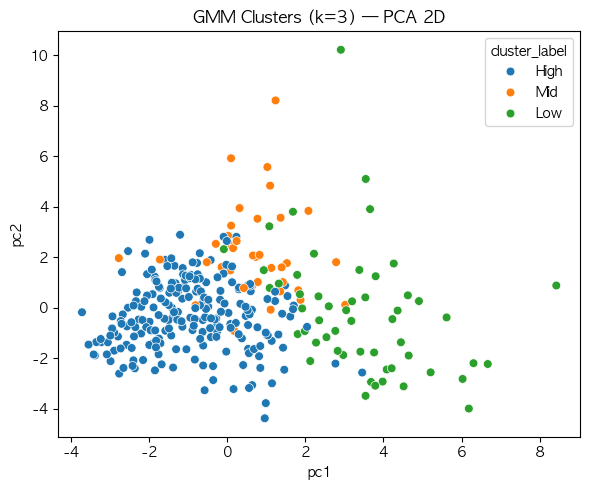

In [16]:
# =========================
# GMM 기반 학생 군집화 (k=3 고정)
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# 1) 사용할 컬럼 지정
base_cols = [
    "fromCity","sex","age","famMore3","liveTogether","Medu","Fedu","noParent",
    "traveltime","studytime","failures","schoolsup","famsup","paid","activities",
    "nursery","higher","internet","romantic","famrel","freetime","goout",
    "Dalc","Walc","health","absences"
]
target_col = "G3"

use_cols = [c for c in base_cols if c in df.columns]
X0 = df[use_cols].copy()
y0 = df[target_col].copy() if target_col in df.columns else None

# yes/no → 1/0 변환
yn_map_cols = ["schoolsup","famsup","paid","activities","nursery","higher","internet","romantic"]
for c in yn_map_cols:
    if c in X0.columns and X0[c].dtype == "object":
        X0[c] = X0[c].map({"yes":1,"no":0})

if "sex" in X0.columns and X0["sex"].dtype == "object":
    X0["sex"] = X0["sex"].map({"M":1,"F":0,"male":1,"female":0}).fillna(X0["sex"])

# object → numeric 변환
for c in X0.columns:
    if X0[c].dtype == "object":
        X0[c] = pd.to_numeric(X0[c], errors="coerce")

# 파생 변수 추가
def add_derived_features(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    if {"Medu","Fedu"}.issubset(df.columns):
        df["parent_edu_combined"] = df["Medu"] + df["Fedu"]
    if {"Dalc","Walc"}.issubset(df.columns):
        df["total_alcohol"] = df["Dalc"] + df["Walc"]
    if "absences" in df.columns:
        df["log_absences"] = np.log1p(df["absences"].clip(lower=0))
    if {"studytime","absences"}.issubset(df.columns):
        df["study_efficiency"]   = df["studytime"] / (1.0 + df["absences"].clip(lower=0))
        df["studytime_absences"] = df["studytime"] * df["absences"]
    if {"Dalc","Walc","freetime"}.issubset(df.columns):
        df["alcohol_freetime"] = (df["Dalc"] + df["Walc"]) * df["freetime"]
    return df

X = add_derived_features(X0)

# 결측 제거
mask = X.notna().all(axis=1)
X = X[mask].copy()
if y0 is not None:
    y = y0.loc[mask].copy()
else:
    y = None

# 스케일링
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
Xs = pd.DataFrame(Xs, index=X.index, columns=X.columns)

# GMM 학습 (k=3 고정)
gmm = GaussianMixture(n_components=3, random_state=42, covariance_type="full")
labels = gmm.fit_predict(Xs)
proba = gmm.predict_proba(Xs)

# 결과 합치기
out = X.copy()
out["cluster"] = labels
if y is not None:
    out["G3"] = y

# === (라벨 재매핑) G3 평균 기준으로 클러스터 라벨 재정렬 + 라벨명 컬럼 추가 ===
if "G3" in out.columns:
    order = out.groupby("cluster")["G3"].mean().sort_values().index           # 낮은 G3 → 높은 G3 순
    remap = {old: new for new, old in enumerate(order)}                        # 0=Low, 1=Mid, 2=High가 되도록 매핑
    out["cluster"] = out["cluster"].map(remap)
    label_names = {0: "Low", 1: "Mid", 2: "High"}
    out["cluster_label"] = out["cluster"].map(label_names)


# 클러스터 요약
print("\n=== 클러스터별 학생 수 ===")
print(out["cluster"].value_counts().sort_index())

if "G3" in out.columns:
    print("\n=== 클러스터별 G3 평균/중앙값 ===")
    # 라벨명까지 함께 보여주면 더 직관적
    print(out.groupby(["cluster","cluster_label"])["G3"].agg(["mean","median"]))

print("\n=== 클러스터별 주요 특성 평균 ===")
key_cols = [c for c in [
    "studytime","absences","study_efficiency","studytime_absences",
    "total_alcohol","alcohol_freetime","goout","health",
    "schoolsup","famsup","failures","parent_edu_combined","traveltime"
] if c in out.columns]
print(out.groupby(["cluster","cluster_label"])[key_cols].mean().round(2))

# 맞춤 전략 생성
global_mean = X.mean()
global_std  = X.std().replace(0, np.nan)

def make_recos(row_mean):
    recos = []
    z = (row_mean - global_mean) / global_std
    def add(msg):
        if msg not in recos: recos.append(msg)

    if "absences" in z and z["absences"] > 0.5: add("출결 관리가 필요합니다. 결석을 줄이는 것을 최우선 과제로 하세요.")
    if "studytime" in z and z["studytime"] < -0.5: add("공부시간이 부족합니다. 매일 1시간 이상 공부 루틴을 만드세요.")
    if "study_efficiency" in z and z["study_efficiency"] < -0.5: add("공부 효율이 낮습니다. 집중 학습(포모도로 기법) 활용을 권장합니다.")
    if "failures" in z and z["failures"] > 0.5: add("낙제 과목이 많습니다. 기초 보충수업부터 시작하세요.")
    if "goout" in z and z["goout"] > 0.5: add("외출 빈도가 높습니다. 일정 관리로 학습 시간을 확보하세요.")
    if "total_alcohol" in z and z["total_alcohol"] > 0.5: add("음주 습관이 높습니다. 주말 음주를 줄여보세요.")
    if "health" in z and z["health"] < -0.5: add("건강 지표가 낮습니다. 충분한 수면과 규칙적 운동이 필요합니다.")
    if "schoolsup" in z and z["schoolsup"] < -0.5: add("학교 보충수업 참여를 고려해보세요.")
    if "famsup" in z and z["famsup"] < -0.5: add("가족의 학습 지원이 낮습니다. 가정 학습 환경 개선이 필요합니다.")

    if not recos:
        recos = ["현재 루틴이 양호합니다. 심화 학습 기회를 제공해도 좋습니다."]
    return recos

print("\n=== 클러스터별 맞춤 전략 ===")
cluster_means = out.groupby("cluster")[key_cols].mean().round(2)
for cid in sorted(cluster_means.index):
    cname = out.loc[out["cluster"]==cid, "cluster_label"].iloc[0]
    print(f"\n[Cluster {cid} - {cname}]")
    for r in make_recos(cluster_means.loc[cid]):
        print(f"- {r}")

# PCA 시각화 (라벨명으로 색상 구분)
pca = PCA(n_components=2, random_state=42)
XY = pca.fit_transform(Xs)
viz = pd.DataFrame({"pc1": XY[:,0], "pc2": XY[:,1]}, index=X.index)
viz["cluster_label"] = out.loc[X.index, "cluster_label"].values

plt.figure(figsize=(6,5))
sns.scatterplot(data=viz, x="pc1", y="pc2", hue="cluster_label", palette="tab10", s=40)
plt.title("GMM Clusters (k=3) — PCA 2D")
plt.tight_layout()
plt.show()


📊 GMM 클러스터링 결과 요약 (k=3)
1. 클러스터별 인원 수 & 성적 요약

| 클러스터 | 라벨   | 학생 수 | 평균 G3 | 중앙값 G3 |
| ---- | ---- | ---- | ----- | ------ |
| 0    | Low  | 53명  | 10.00 | 9.0    |
| 1    | Mid  | 39명  | 10.36 | 10.0   |
| 2    | High | 223명 | 12.23 | 12.0   |


- High 그룹: 전체의 약 66%, 평균 12.23점으로 성적 상위권

- Low 그룹: 전체의 약 16%, 평균 10.0점으로 성적 관리 필요

- Mid 그룹: 전체의 약 12%, 중간권 학생군

2. 주요 특성 비교

| 특성                | Low         | Mid        | High       | 인사이트 요약               |
| ----------------- | ----------- | ---------- | ---------- | --------------------- |
| 결석(absences)      | **14.81 ↑** | 10.49      | 3.98 ↓     | 출결이 성적에 큰 영향을 미침      |
| 공부시간(studytime)   | 1.72 ↓      | 2.03       | 2.16       | 성적 높은 그룹일수록 공부시간 확보 ↑ |
| 공부효율(study_eff.)  | **0.25 ↓**  | 0.37       | **0.90 ↑** | Low 그룹은 결석↑ → 공부효율 ↓  |
| 낙제(failures)      | 0.58        | **1.15 ↑** | **0.02 ↓** | Mid 그룹이 낙제 과목 가장 많음   |
| 음주(total_alcohol) | **6.64 ↑**  | 3.41       | 3.12       | Low 그룹 음주 습관이 가장 높음   |
| 외출(goout)         | **4.04 ↑**  | 2.72       | 2.91       | Low 그룹의 외출 빈도 높음      |


3. 클러스터별 맞춤 전략

[Low 그룹]


- 출결 관리 최우선: 결석 줄이기 위한 알림·상담 프로그램

- 공부 효율 개선: 포모도로 학습법, 집중 블록 학습 시간 확보

- 음주·외출 관리: 생활습관 교정 프로그램, 건강관리 지원

- 낙제 과목 보충: 기초 복습·보충수업 참여


[Mid 그룹]


- 낙제 과목 관리: 학습 진도 점검 + 개별 튜터링 지원

- 중간권 학생군 → 성적 향상 잠재력 있음


[High 그룹]


- 현재 루틴 양호 → 심화 학습, 대회 준비, 자기주도 학습 기회 제공

In [1]:
# === 단일 학생 입력 → 추천 ===
# - G3: 0~20
# - studytime: 1~4 (1:<2h, 2:2~5h, 3:5~10h, 4:10h+)
# - absences: 0 이상 정수

def ask_int(prompt, min_v=None, max_v=None):
    while True:
        try:
            v = int(input(prompt).strip())
            if (min_v is not None and v < min_v) or (max_v is not None and v > max_v):
                rng = []
                if min_v is not None: rng.append(f"{min_v}")
                if max_v is not None: rng.append(f"{max_v}")
                print(f"⚠️ 범위 오류: {min_v}~{max_v} 사이로 입력하세요.")
                continue
            return v
        except ValueError:
            print("⚠️ 정수를 입력하세요.")

# 1) 입력
G3 = ask_int(" G3 (0~20): ", 0, 20)
studytime = ask_int("주당 공부시간 등급 studytime: ", 1, 4)
absences = ask_int("결석 횟수 absences (0 이상): ", 0, 9999)

# 2) 규칙 기반 평가
msgs = []
tips = []

# 성적 평가
if G3 < 10:
    msgs.append("📉 성적 낮음: 기초 개념 복습과 주간 진도 점검이 필요합니다.")
elif G3 < 13:
    msgs.append("➡️ 성적 보통: 약점 과목을 중심으로 꾸준히 보완하세요.")
else:
    msgs.append("✅ 성적 양호: 현재 루틴을 유지하되 심화 학습을 고려하세요.")

# 결석 평가
if absences >= 20:
    msgs.append("🚨 결석 매우 많음: 출결 관리가 최우선 과제입니다. 알림·담임 상담을 바로 시작하세요.")
elif absences >= 10:
    msgs.append("⚠️ 결석 많음: 결석을 줄이는 계획(기상·등교 루틴)부터 세우세요.")
elif absences >= 5:
    msgs.append("ℹ️ 결석 보통: 다음 달까지 결석 0~2회로 관리해보세요.")
else:
    msgs.append("👍 결석 관리 양호: 현 상태 유지.")

# 공부시간 평가 (studytime: 1~4)
if studytime == 1:
    msgs.append("⏱️ 공부시간 부족: 매일 1시간 고정 블록부터 시작하세요.")
    tips.append("포모도로(25분 집중/5분 휴식) 3세트로 75분 확보.")
elif studytime == 2:
    msgs.append("⏱️ 공부시간 보통: 주 7~10시간으로 점진 확대를 권장합니다.")
    tips.append("평일 60분×5일 + 주말 2시간.")
elif studytime == 3:
    msgs.append("⏱️ 공부시간 양호: 약점 과목 위주로 집중하세요.")
else:  # 4
    msgs.append("⏱️ 공부시간 충분: 심화 문제/서술형 대비를 추가하세요.")

# 3) 조합 규칙 (우선순위 메시지)
if absences >= 10 and studytime >= 3:
    tips.append("🎯 우선순위: 공부시간이 충분해도 결석이 많으면 성과가 제한됩니다 → 출결 먼저.")
if absences >= 10 and G3 < 10:
    tips.append("🎯 조기개입: 담임/보호자와 함께 ‘출결+기초보충’ 단기 계획(2주) 세우기.")
if studytime == 1 and G3 < 13:
    tips.append("🎯 루틴: 매일 같은 시간(예: 20:00~21:00)로 습관화를 시작하세요.")

# 4) 요약 출력
print("\n=== 개인 맞춤 추천 ===")
print(f"-G3={G3}, studytime={studytime} (1~4단계), absences={absences}")
print("\n[핵심 권장 사항]")
for m in msgs:
    print("-", m)
if tips:
    print("\n[실행 팁]")
    for t in tips:
        print("-", t)



⚠️ 범위 오류: 1~4 사이로 입력하세요.
⚠️ 범위 오류: 1~4 사이로 입력하세요.
⚠️ 범위 오류: 1~4 사이로 입력하세요.
⚠️ 범위 오류: 1~4 사이로 입력하세요.
⚠️ 범위 오류: 1~4 사이로 입력하세요.

=== 개인 맞춤 추천 ===
-G3=5, studytime=1 (1~4단계), absences=2

[핵심 권장 사항]
- 📉 성적 낮음: 기초 개념 복습과 주간 진도 점검이 필요합니다.
- 👍 결석 관리 양호: 현 상태 유지.
- ⏱️ 공부시간 부족: 매일 1시간 고정 블록부터 시작하세요.

[실행 팁]
- 포모도로(25분 집중/5분 휴식) 3세트로 75분 확보.
- 🎯 루틴: 매일 같은 시간(예: 20:00~21:00)로 습관화를 시작하세요.
